# Learning Exercise -- birds images

## 챕터의 컨셉  
- feedforward nn: layer forwarding에 순환이 없다
- 제공된 Datasets, 불러오는 법
- classification loss 사용

# Dataset
: 데이터를 편하게 다루기 위해 사용되는 객체  
이후 Dataset -> DataLoader

CIFAR-10 -- CIFAR기관의 10classes 데이터 사용

In [7]:
from torchvision import datasets
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=False) 
cifar10_val = datasets.CIFAR10(data_path, train=False, download=False)

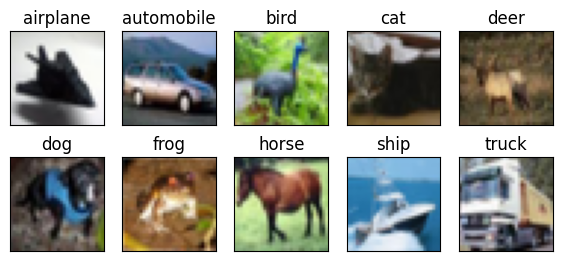

In [8]:
import matplotlib.pyplot as plt

#그냥 이미지 시각화 방법이라는 것만...
class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(7,3)) 
num_classes = 10

for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[]) 
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i) 
    plt.imshow(img)
plt.show()

# Dataset Class
-> 사진데이터 PIL로 관리
### 문제: Dataset의 데이터타입 = PIL.Image // 학습시키려면 tensor 타입필요
=> torchvision.ToTensor()로 문제해결

In [9]:
img, label = cifar10[104]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 6, 'frog')

# Data Preprocessing

In [10]:
from torchvision import transforms
to_tensor = transforms.ToTensor()

#PIL to tensor
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

### Datasets.permute()

In [11]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download= False, transform = transforms.ToTensor())
# dataset의 축 변환이 쉽다... CHW->HWC
img_t = img_t.permute(1,2,0)

### torchvision.transforms.Normalize
- tensor.view() == numpy.reshape()
- dim = dim of calculation

In [12]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3) # 4번째 차원에 50000개가 차곡차곡 쌓인다

In [13]:
# reshape 3,_ => dim=1 -> _에 대해 평균값을 구한다는 의미
means = imgs.view(3,-1).mean(dim=1)
#마찬가지
std = imgs.view(3,-1).std(dim=1)

transform = transforms.Normalize(means, std)

### want to uset ToTensor&Normalize -> Compose

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


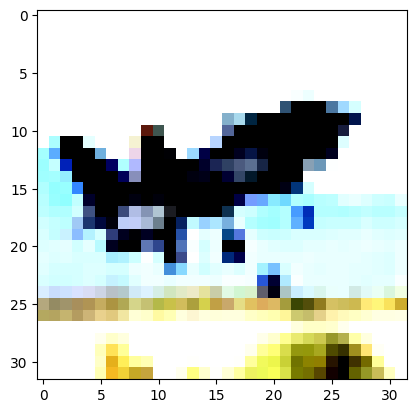

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, std)
])
# -> 이걸이제 dataset을 불러올 때, transform = transform으로

transformed_cifar10 = datasets.CIFAR10(
    data_path, train = True, download =False, transform = transform
)

img_t, _ = transformed_cifar10[1434]
plt.imshow(img_t.permute(1,2,0)) # pytorch에 편의상 채널을 먼저 사용하지만 plt는 아니라는 사실

# Classification Setting

In [15]:
transformed_cifar10_val = datasets.CIFAR10(
    data_path, train = False, download =False, transform = transforms.ToTensor()
)

label_map = {0:0, 2:1}
class_name = ['airplane', 'bird']

cifar2 = [(img, label_map[label])
              for img, label in transformed_cifar10
              if label in [0,2]]
cifar2_val = [(img, label_map[label])
           for img, label in transformed_cifar10_val
           if label in [0,2]]

### Model 설계
image 3x32x32 = 3076개의 인풋노드  
hidden ~ 마음대로 정하시고  
output ~ 2개

In [16]:
import torch.nn as nn
import torch as torch

n_class = 2 # binary classfication

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, n_class)
)

# About categorical output

## **activation = softmax
### nn.Softmax(dim=_)

In [17]:
# x는 tensor -> 결과값도 prob를 담은 tensor
def softmax(x):
    return torch.exp(x)/torch.exp(x).sum()

# samples:0 그 다음이 softmax로 들어갈거잖아..
softmax = nn.Softmax(dim=1)

In [18]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    softmax
)

### input data 핸들링
3x32x32x50000의 데이터형식 -> 50000x3072로 바꿔줘야한다.  
채널도 결국 통합된다. 채널별 normalize 할 때는 포함안했지만

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.4911, 0.5089]], grad_fn=<SoftmaxBackward0>)

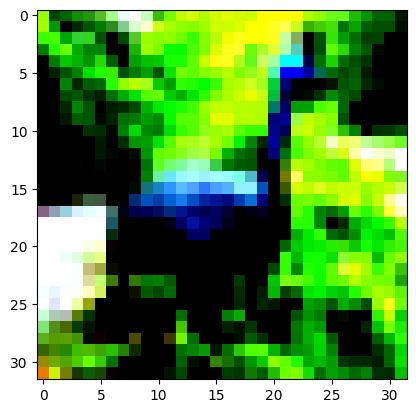

In [19]:
#우선 이미지 1개에 대한 = stochastic case
img,_ = cifar2[0]
img_batch = img.view(-1).unsqueeze(0)
out = model(img_batch)
plt.imshow(img.permute(1,2,0))
out

### get output 깔끔하게

In [20]:
_, index = torch.max(out, dim=1) #index값을 얻기 위해서 torch.max(TENSOR, dim)
print(index)
class_name[int(index)]

tensor([1])


'bird'

## **Loss = NLL
-> CrossEntropy

In [21]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1) #categorical 배열은 dim=1에서 이뤄진다.
)

loss = nn.NLLLoss()

img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.4846, grad_fn=<NllLossBackward0>)

# Real Training

In [22]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr = 1e-2)
loss_fn = nn.NLLLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2[:1000]:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))


Epoch: 0, Loss: 0.514946
Epoch: 1, Loss: 0.034172
Epoch: 2, Loss: 0.119406
Epoch: 3, Loss: 0.031277
Epoch: 4, Loss: 0.722574
Epoch: 5, Loss: 0.293536
Epoch: 6, Loss: 0.702058
Epoch: 7, Loss: 0.090503
Epoch: 8, Loss: 0.655748
Epoch: 9, Loss: 0.142171
Epoch: 10, Loss: 0.532453
Epoch: 11, Loss: 0.055809
Epoch: 12, Loss: 2.593108
Epoch: 13, Loss: 0.089468
Epoch: 14, Loss: 3.082019
Epoch: 15, Loss: 0.063068
Epoch: 16, Loss: 0.704832
Epoch: 17, Loss: 0.078821
Epoch: 18, Loss: 1.656619
Epoch: 19, Loss: 1.568329
Epoch: 20, Loss: 4.399370
Epoch: 21, Loss: 0.183630
Epoch: 22, Loss: 0.034337
Epoch: 23, Loss: 1.399521
Epoch: 24, Loss: 0.191809
Epoch: 25, Loss: 0.123752
Epoch: 26, Loss: 3.522984
Epoch: 27, Loss: 7.046236
Epoch: 28, Loss: 1.163493
Epoch: 29, Loss: 0.089017
Epoch: 30, Loss: 0.059040
Epoch: 31, Loss: 0.259291
Epoch: 32, Loss: 0.004651
Epoch: 33, Loss: 0.203177
Epoch: 34, Loss: 6.826848
Epoch: 35, Loss: 0.149521
Epoch: 36, Loss: 1.138230
Epoch: 37, Loss: 7.024659
Epoch: 38, Loss: 0.976

-> 코드를 보면 1epoch 50000 update임을 알 수 있다..

### To better, SGD
shuffled -> splited batches -> batch 별 loss의 평균으로 학습  
accumulated_loss of batch => gradient descent  
  
shuffling 등 데이터셋의 가공이 필요한 상황 => Data Loader!!

# Data Loader
(Datasets) -- (DataLoader) --> well cleared data to training  
=> shuffle! minibatch_size!

In [23]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle= True)

### DataLoader in training

In [24]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = True)

for epoch in range(1, 1+n_epochs):
    True
    # epoch 에서 batch를 떼어줄 때 in data_loader에서 불러옴
    for imgs, labels in train_loader:
        True

In [29]:
for epoch in range(1, 1+n_epochs):
    for imgs, labels in train_loader:
        out = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(out, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


### DataLoader in validation

In [30]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size = 64, shuffle = False)

total = 0
correct = 0

# predicting만 하므로 epoch 반복이 없다
# 대신 grad를 쓰지 않는 torch.no_grad()맥락에서 시행되면좋다.
with torch.no_grad():
    for imgs, labels in val_loader:
        output = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(output, dim = 1)
        
        #맞은량/전체량
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
print("Accuracy: %f" % (correct/total))

Accuracy: 0.534500


## **Loss = CrossEntropy

In [33]:
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2)
)
loss_fn = nn.CrossEntropyLoss()

# Fully Connect NN의 한계점

### 1. Fully Connect with LARGE datainput == LARGE params
- 64x64 해상도 사진? 3x64x64xH + H 만큼의 파라미터 in 1Layer

  
### 2. NOT translation invariants
- pixel = 데이터, pixel 사이의 관계에 대한 정보 X
- 사용하는 데이터는 많은데... 상대정보(주변값)를 고려하지 않는다..

# Keyword listup
- torchvision -> transforms -> transforms.ToTensor => Method() 유의
- nn.model Sequential 구성시 input output nodes 고려할 것
- torch.stack([], dim)
- torchvision.transforms.Compose([_])
- tensor.view()
- Sequential() vs Compose([])
- torch.utils.data.DataLoader(DATA, batch_size, shuffle)